# Part one: Download and explore data from Wikipedia
## Using pandas
First, import necessary packages

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library



### Scraping website for table 
I used the pandas 'read_html' method to generate a list of tables; the first table in this list is the desired table, so I assign it to the variable df.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(url)
df = tables[0]

### Cleaning dataframe 
Next, I replace all 'Not assigned' values with NaN; then, per instructions, I ignore (remove from dataframe) all 'Not assigned' values for Borough. In addition, I rename all 'Not assigned' values from Neighbourhood with the value in that observation's value in the Borough column.

In [3]:
df.replace('Not assigned', np.nan, inplace = True)
df.dropna(subset=["Borough"], axis=0, inplace=True)
df["Neighbourhood"].replace(np.nan, df["Borough"], inplace=True)
df

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


I then use the shape method to determine the shape of the new dataframe.

In [4]:
df.shape

(103, 3)

# Part two: Latitude and longitude
## Using provided coordinates
NOTE: The geocoder package could not be loaded, so I used the provided data. (Output: "ModuleNotFoundError: No module named 'geocoder'")

In [5]:
coords = pd.read_csv(r'Desktop/Geospatial_Coordinates.csv')
coords

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


I merged the provided postal data with the table scraped from Wikipedia.

In [6]:
df_complete = df.merge(coords, how='inner', left_on=["Postal Code"], right_on=["Postal Code"])
df_complete.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# Part three: Explore and cluster the neighborhoods in Toronto
Now that the data is collected into one data frame, I am going to look at how the neighbourhoods cluster.

#### First, I installed geopy and geocoders.

In [7]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

# All requested packages already installed.



#### Next I set up the information for Toronto to later be used in the mapping.

In [8]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronoto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### I chose to follow the instructions indicating that we can use the subset of Boroughs with 'Toronto' in the name. I call this dataframe 'df_subset'.

In [9]:
df_complete.Borough.unique()
subset = ['Downtown Toronto', 'Central Toronto', 'West Toronto', 'East Toronto']
df_subset = df_complete[df_complete.Borough.isin(subset)]
df_subset.reset_index(inplace = True, drop = True)
df_subset

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


#### Finally, I create a map with folium using the postal codes' latitudes, longitudes, and neighborhood names.

In [10]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_subset['Latitude'], df_subset['Longitude'], df_subset['Borough'], df_subset['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

I input my Foursquare API credentials; this data is in a hidden cell.

In [11]:
# @hidden_cell
CLIENT_ID = 'JOOTJPHIS1WAAI23Y0MEGCOZEQX504L1O1SPHIRW2GGNVSMH' # your Foursquare ID
CLIENT_SECRET = 'GI3MS31UFZSUJVTEJSTMQ13EE1MKF1ELIDRFMTC1WN4DRCM1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JOOTJPHIS1WAAI23Y0MEGCOZEQX504L1O1SPHIRW2GGNVSMH
CLIENT_SECRET:GI3MS31UFZSUJVTEJSTMQ13EE1MKF1ELIDRFMTC1WN4DRCM1


#### I will use a function _getNearbyVenues_ to get the top 100 venues that are in the neighborhoods in _df_subset_ within a radius of 500 meters. First, I establish several variables to be used in the function.

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display URL

NameError: name 'neighbourhood_latitude' is not defined

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I execute this function for the _df_subset_ dataframe, assess the resulting dataframe's shape and format, then group by Neighborhood.

In [14]:
Toronto_venues = getNearbyVenues(names=df_subset['Neighbourhood'],
                                   latitudes=df_subset['Latitude'],
                                   longitudes=df_subset['Longitude']
                                  )



Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [15]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1631, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [16]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",14,14,14,14,14,14
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,65,65,65,65,65,65
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37


In [17]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


In [18]:
Toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
...,...,...,...,...,...,...,...
1626,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,The Ashbridge Estate,43.664691,-79.321805,Garden
1627,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1628,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1629,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Greenwood Cigar & Variety,43.664538,-79.325379,Smoke Shop


#### The next step is to assign dummy variables in order to cluster according to category of venue. I used one-hot encoding to assign dummy variables, then grouped again by Neighborhood.

In [19]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

Toronto_onehot.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
Toronto_onehot.shape

(1631, 234)

In [21]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head(25)

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.017241,0.00,0.000000,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.015385,0.00,0.000000,0.015385,0.0,0.015385
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000
6,Church and Wellesley,0.012987,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012987,0.000000,...,0.012987,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.025974
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,0.000000,...,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.000000,0.010000,0.0,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.027027,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000


##### To get a taste for the data, I looked at the top venue type in each neighborhood.

In [22]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1        Cocktail Bar  0.03
2            Beer Bar  0.03
3  Seafood Restaurant  0.03
4         Cheese Shop  0.03


----Brockton, Parkdale Village, Exhibition Place----
                  venue  freq
0                  Café  0.13
1           Coffee Shop  0.09
2        Breakfast Spot  0.09
3  Gym / Fitness Center  0.04
4    Italian Restaurant  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.07
1         Garden Center  0.07
2            Comic Shop  0.07
3           Pizza Place  0.07
4            Restaurant  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2     Airport Terminal  0.12
3  Rental Car Location  0.06
4   Airport Food Court  0.06


----Centr

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Bakery,Café,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Greek Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym / Fitness Center,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Gym / Fitness Center,Fast Food Restaurant,Park,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Sculpture Garden,Airport,Airport Food Court,Airport Gate,Bar,Harbor / Marina,Rental Car Location
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Japanese Restaurant,Italian Restaurant,Burger Joint,Bubble Tea Shop,Department Store,Salad Place,Restaurant
5,Christie,Grocery Store,Café,Park,Restaurant,Candy Store,Baby Store,Athletics & Sports,Italian Restaurant,Diner,Nightclub
6,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Café,Men's Store,Mediterranean Restaurant,Hotel,Yoga Studio
7,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant,Thai Restaurant,Italian Restaurant
8,Davisville,Sandwich Place,Dessert Shop,Coffee Shop,Pizza Place,Café,Sushi Restaurant,Gym,Italian Restaurant,Farmers Market,Indoor Play Area
9,Davisville North,Gym / Fitness Center,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Sandwich Place,Gym,American Restaurant,Discount Store


### K-means clustering
To cluster the neighborhoods according to the most popular venues within them, I removed 'Neighborhood' from the datatframe and used the Elbow Method to show the optimal 'k'. It appears to 'elbow' at 7, so I ran my final k-means cluster analysis with k = 7.

In [41]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
#Toronto_grouped_clustering = Toronto_grouped

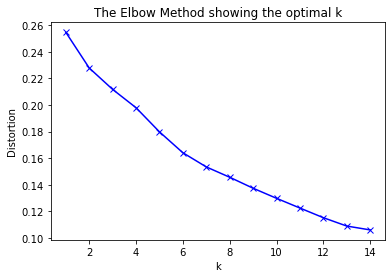

In [45]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init = 30).fit(Toronto_grouped_clustering)
    kmeanModel.fit(Toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(Toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [46]:
# set number of clusters according to Elbow Method

#While there's no clear elbow, after running the Elbow Method multiple times with different
#values of iterations, 8 seems to frequently be the closest thing to an inflexion point.
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 4, 4, 1, 1], dtype=int32)

Then I inserted the cluster labels into the _neighborhoods_venues_sorted_ dataframe to assign the results to the observations. Then, I merged that dataframe to the _df_subset_ (that is, the dataframe with the neighborhoods, boroughs, postal codes, and long/lat data), using the common neighborhood values to merge them.

In [52]:
# add clustering labels (first drop in case already exists)
neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_subset

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')


In [53]:
Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4,Coffee Shop,Bakery,Pub,Café,Park,Restaurant,Breakfast Spot,Theater,Yoga Studio,Farmers Market
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Café,Portuguese Restaurant,Persian Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Diner,Bookstore,Pizza Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Café,Coffee Shop,Clothing Store,Restaurant,Cosmetics Shop,American Restaurant,Cocktail Bar,Breakfast Spot,Gym,Hotel
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Pub,Health Food Store,Trail,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant


I mapped this data using the longitude and latitude data and assigning colors by cluster index.

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Assessing the clusters
I took a look at the postal codes that populated each cluster:

In [55]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M4E,East Toronto,The Beaches,0,Asian Restaurant,Pub,Health Food Store,Trail,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant


In [56]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,M4L,East Toronto,"India Bazaar, The Beaches West",1,Park,Sandwich Place,Brewery,Liquor Store,Board Shop,Burrito Place,Italian Restaurant,Restaurant,Fast Food Restaurant,Fish & Chips Shop
20,M4P,Central Toronto,Davisville North,1,Gym / Fitness Center,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Sandwich Place,Gym,American Restaurant,Discount Store
26,M4S,Central Toronto,Davisville,1,Sandwich Place,Dessert Shop,Coffee Shop,Pizza Place,Café,Sushi Restaurant,Gym,Italian Restaurant,Farmers Market,Indoor Play Area


In [57]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,2,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [58]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,M4T,Central Toronto,"Moore Park, Summerhill East",3,Restaurant,Trail,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [59]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",4,Coffee Shop,Bakery,Pub,Café,Park,Restaurant,Breakfast Spot,Theater,Yoga Studio,Farmers Market
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4,Coffee Shop,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Café,Portuguese Restaurant,Persian Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",4,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Diner,Bookstore,Pizza Place
3,M5C,Downtown Toronto,St. James Town,4,Café,Coffee Shop,Clothing Store,Restaurant,Cosmetics Shop,American Restaurant,Cocktail Bar,Breakfast Spot,Gym,Hotel
5,M5E,Downtown Toronto,Berczy Park,4,Coffee Shop,Farmers Market,Bakery,Café,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Greek Restaurant
6,M5G,Downtown Toronto,Central Bay Street,4,Coffee Shop,Sandwich Place,Café,Japanese Restaurant,Italian Restaurant,Burger Joint,Bubble Tea Shop,Department Store,Salad Place,Restaurant
7,M6G,Downtown Toronto,Christie,4,Grocery Store,Café,Park,Restaurant,Candy Store,Baby Store,Athletics & Sports,Italian Restaurant,Diner,Nightclub
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",4,Coffee Shop,Café,Gym,Restaurant,Hotel,Clothing Store,Thai Restaurant,Bar,Steakhouse,Sushi Restaurant
9,M6H,West Toronto,"Dufferin, Dovercourt Village",4,Pharmacy,Bakery,Smoke Shop,Bank,Supermarket,Middle Eastern Restaurant,Café,Pizza Place,Art Gallery,Music Venue
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",4,Coffee Shop,Aquarium,Hotel,Café,Scenic Lookout,Restaurant,Fried Chicken Joint,Brewery,Italian Restaurant,Baseball Stadium


In [60]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",5,Jewelry Store,Trail,Sushi Restaurant,Bus Line,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [61]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,M4W,Downtown Toronto,Rosedale,6,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [62]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 7, Toronto_merged.columns[[0,1,2] + list(range(5, Toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,M4N,Central Toronto,Lawrence Park,7,Park,Swim School,Bus Line,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


## Considering the results

Looking at the clusters, it's clear that the most abundant cluster is Cluster 4, which is a cluster of postal codes that share a high frequency of coffee shops and cafés. Cluster 1 is a cluster of postal codes that share a high frequency of sandwich places in comparison to the other postal codes. 


Clusters 0, 2, 3, 5, 6 and 7 are all clusters with only one postal code, and therefore, it seems that the diversity among them with regards to their most frequent venues was greater than the commonality among them. 


Given the obtuseness of the elbow observed in the Elbow Method, it's not surprising that there are many clusters with only one postal code: the more clusters you add, the more error will be accounted for, but not necessarily because the data is being classified more categorically because of the number of dimensions under consideration -- i.e., the 10 most common venue types.

In order to probe this, I ran the analyses with 5, 10, and 15 most common venues. In each case, the "elbow" is always obtuse (i.e., there is no clear point when the reduction of error by adding an additional cluster is considerably different from the reduction of error by removing a cluster). With each of these analyses, I found that there is always one cluster that is considerably larger than the other clusters, which have between one and three postal codes. 

Therefore, I followed the outline presented in the practice lab on NY neighborhoods, in which there was also one dominant cluster, with several other clusters populated by few neighborhoods.
